Importing the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,UpSampling2D,Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D,MaxPooling3D,BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
train='../input/active-galactic-nuclei-image-dataset/AGN_split/train'
val='../input/active-galactic-nuclei-image-dataset/AGN_split/val'
test='../input/active-galactic-nuclei-image-dataset/AGN_split/test'

trainn=tf.keras.preprocessing.image.ImageDataGenerator(
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         rescale=1./255)

testt=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_set=trainn.flow_from_directory(train,target_size=(300,300),
        batch_size=10,
        class_mode='binary'
)
val_set=testt.flow_from_directory(val,target_size=(300, 300),
        batch_size=10,
        class_mode='binary',shuffle=False
)
test_set=testt.flow_from_directory(test,target_size=(300,300),
        batch_size=10,
        class_mode='binary',shuffle=False
)

Found 3229 images belonging to 2 classes.
Found 403 images belonging to 2 classes.
Found 405 images belonging to 2 classes.


Forming the architecture

In [3]:
#VGG=tf.keras.applications.vgg19.VGG19(
    #include_top=False, weights='imagenet', 
    #input_shape=(150,150,3), pooling=max
#)
eff=tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False, weights='imagenet',
    input_shape=(300,300,3), pooling=max
)

for layer in eff.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
        
model = Sequential()
model.add(eff)
#model.add(layers.GlobalMaxPooling2D(name="gap"))
model.add(GlobalAveragePooling2D())
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(.3))
#model.add(BatchNormalization())
#model.add(Flatten())
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(.3))
#model.add(BatchNormalization())
#model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(.3))
#model.add(BatchNormalization())
#model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
#model.add(Dropout(.3))
#model.add(BatchNormalization())
model.summary()

71688192/71686520 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 10, 10, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1793      
Total params: 17,675,616
Trainable params: 126,993
Non-trainable params: 17,548,623
_________________________________________________________________


In [4]:
# Freezing first seven layers
#for layer in model.layers[:-4]:
    #layer.trainable = False

model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=4e-5),metrics=['accuracy'])

In [5]:
name= 'AGN1.h5'

rlr = ReduceLROnPlateau(monitor = 'val_acc', factor = 0.1, patience = 2, verbose = 1, 
                                min_delta = 1e-4, min_lr = 1e-6, mode = 'min', cooldown=1)
        
ckp = ModelCheckpoint(name,monitor = 'val_acc',
                      verbose = 1, save_best_only = True, mode = 'min')
        
es = EarlyStopping(monitor = 'val_acc', min_delta = 1e-4, patience = 6, mode = 'min', 
                    restore_best_weights = True, verbose = 1)

In [6]:
import math
# Train the model
his1= model.fit(
                                train_set,
                                steps_per_epoch = train_set.samples//train_set.batch_size,
                                epochs = 50,
                                validation_data = val_set,
                                validation_steps = val_set.samples//val_set.batch_size,
                                callbacks=[rlr, ckp, es])


Epoch 1/50
322/322 [==============================] - 274s 771ms/step - loss: 0.7046 - accuracy: 0.4777 - val_loss: 0.6933 - val_accuracy: 0.5025
Epoch 2/50
322/322 [==============================] - 223s 694ms/step - loss: 0.6959 - accuracy: 0.5058 - val_loss: 0.7025 - val_accuracy: 0.5000
Epoch 3/50
322/322 [==============================] - 222s 690ms/step - loss: 0.6963 - accuracy: 0.5093 - val_loss: 0.6799 - val_accuracy: 0.5650
Epoch 4/50
322/322 [==============================] - 227s 705ms/step - loss: 0.6904 - accuracy: 0.5367 - val_loss: 0.6780 - val_accuracy: 0.5625
Epoch 5/50
322/322 [==============================] - 229s 712ms/step - loss: 0.6887 - accuracy: 0.5228 - val_loss: 0.6742 - val_accuracy: 0.5675
Epoch 6/50
322/322 [==============================] - 230s 713ms/step - loss: 0.6852 - accuracy: 0.5570 - val_loss: 0.6693 - val_accuracy: 0.6050
Epoch 7/50
322/322 [==============================] - 236s 733ms/step - loss: 0.6856 - accuracy: 0.5444 - val_loss: 0.6667 -

Text(0.5, 1.0, 'loss')

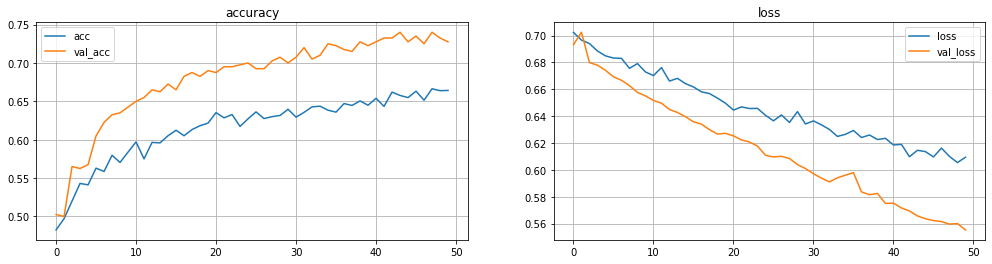

In [7]:
fig = plt.figure(figsize = (17, 4))
    
plt.subplot(121)
plt.plot(his1.history['accuracy'], label = 'acc')
plt.plot(his1.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(his1.history['loss'], label = 'loss')
plt.plot(his1.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')